# 5.2 Meta-learners（T-Learner、S-Learner、X-Learner）の実装

本ファイルは、5.2節の実装です。

第1章から取り上げている、人事研修の効果について因果推論を実施します。

## プログラム実行前の設定など

In [1]:
# 乱数のシードを設定
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)


In [3]:
# 使用するパッケージ（ライブラリと関数）を定義
# 標準正規分布の生成用
from numpy.random import *

# グラフの描画用
import matplotlib.pyplot as plt

# SciPy 平均0、分散1に正規化（標準化）関数
import scipy.stats

# シグモイド関数をimport
from scipy.special import expit

# その他
import pandas as pd


## データの作成

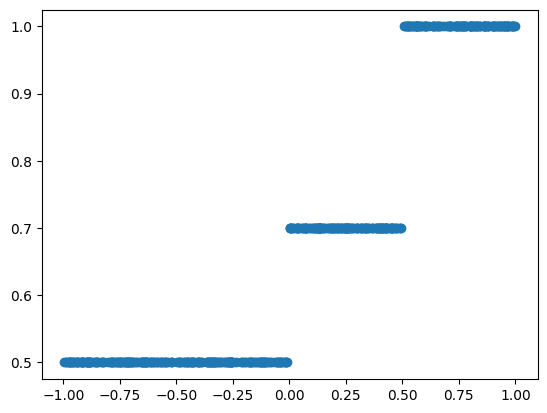

In [4]:
# データ数
num_data = 500

# 部下育成への熱心さ
x = np.random.uniform(low=-1, high=1, size=num_data)  # -1から1の一様乱数

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
e_z = randn(num_data)  # ノイズの生成
z_prob = expit(-1*-5.0*x+5*e_z)  # xの効果が反対になっていたのを修正Issue：#18
Z = np.array([])

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)

# 介入効果の非線形性：部下育成の熱心さxの値に応じて段階的に変化
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0

e_y = randn(num_data)
Y = 2.0 + t*Z + 0.3*x + 0.1*e_y 

# 介入効果を図で確認
plt.scatter(x, t, label="treatment-effect")


## データをまとめた表を作成し、可視化する

In [5]:
df = pd.DataFrame({'x': x,
                   'Z': Z,
                   't': t,
                   'Y': Y,
                   })

df.head()  # 先頭を表示


,x,Z,t,Y
0,-0.616961,0.0,0.5,1.803183
1,0.244218,1.0,0.7,2.668873
2,-0.124545,0.0,0.5,2.193123
3,0.570717,1.0,1.0,3.245229
4,0.559952,1.0,1.0,3.139868


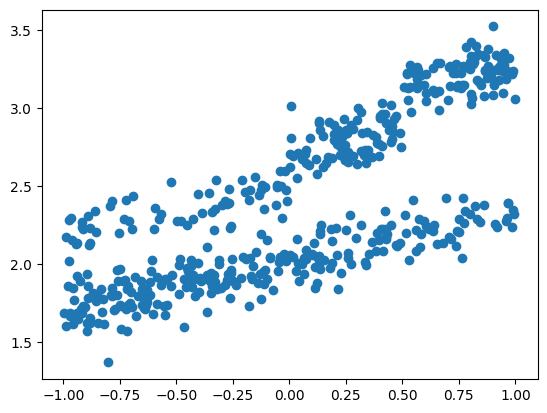

In [6]:
plt.scatter(x, Y)


# 生成モデル
- 外生変数
  - $e_x$, $e_y$, $e_z$
- 内生変数
  - $X$, $Y$, $Z$
- 構造方程式
  $$
  \begin{align}
  X &= e_x \sim \mathrm{Unif(-1,1)} \\
  Y &= \alpha_0 + t(X)Z + \alpha_1 X + \alpha_2 e_y,\quad e_y \sim \mathcal{N}(0,1) \\
  z_\mathrm{prob}(X) &= {1 \over 1 + e^{\beta_0 X + \beta_1 e_z}},\quad e_z \sim \mathcal{N}(0,1)\\
  Z &= \chi_{z_\mathrm{prob}(X)>1/2}
  \end{align}
  $$

  ただし，
  $$
  t(x) = \begin{cases}
  0 & x\le 0 \\
  0.7 & 0<x\le 0.5 \\
  1.0 & x < 0.5
  \end{cases}
  $$
  と書いた
  
# 実装上の数値例
$$
\begin{align}
\alpha_0 &= 2.0 \\
\alpha_1 &= 0.3 \\
\alpha_2 &= 0.1 \\
\beta_0 &= 5.0 \\
\beta_1 &= 5.0
\end{align}
$$

## T-Learner

In [10]:
# 集団を2つに分ける
df_0 = df[df.Z == 0.0]  # 介入を受けていない集団
df_1 = df[df.Z == 1.0]  # 介入を受けた集団


In [17]:
# それぞれの数
df['Z'].value_counts()

0.0    262
1.0    238
Name: Z, dtype: int64

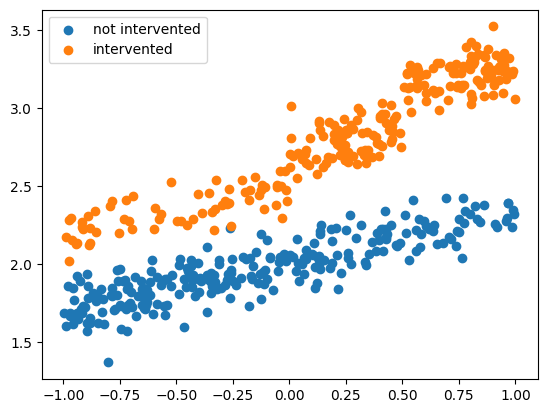

In [18]:
# 集団ごとの可視化
plt.scatter(df_0['x'], df_0['Y'], label='not intervented')
plt.scatter(df_1['x'], df_1['Y'], label='intervented')
plt.legend()
plt.show()

In [20]:
# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# 介入を受けていないモデル
reg_0 = RandomForestRegressor(max_depth=3)
reg_0.fit(df_0[["x"]], df_0[["Y"]])

# 介入を受けたモデル
reg_1 = RandomForestRegressor(max_depth=3)
reg_1.fit(df_1[["x"]], df_1[["Y"]])


/Users/kouta/Works/causal_book/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/kouta/Works/causal_book/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


RandomForestRegressor(max_depth=3)

In [22]:
# 予測値を付与
df_0['Y_pred'] = reg_0.predict(df_0[['x']])
df_1['Y_pred'] = reg_1.predict(df_1[['x']])

/Users/kouta/Works/causal_book/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kouta/Works/causal_book/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Intervented')

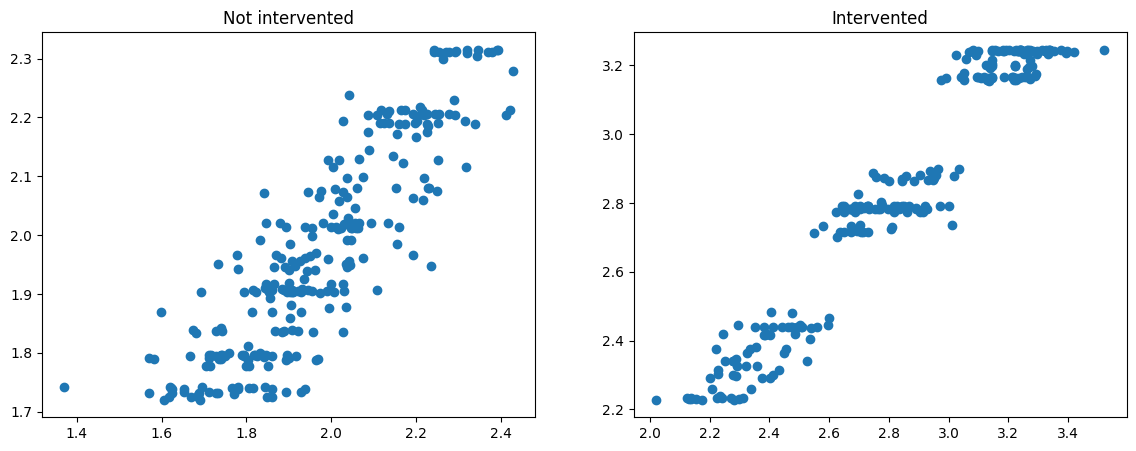

In [31]:
# 散布図を確認
fig, axes = plt.subplots(1,2,figsize=(14,5))

axes[0].scatter(df_0['Y'], df_0['Y_pred'])
axes[1].scatter(df_1['Y'], df_1['Y_pred'])

axes[0].set_title('Not intervented')
axes[1].set_title('Intervented')


In [8]:
# ATEを求める
mu_0 = reg_0.predict(df[["x"]])
mu_1 = reg_1.predict(df[["x"]])

ATE = (mu_1-mu_0).mean()
print("ATE：", ATE)


ATE： 0.6678485877933638


In [32]:
# 処置群における平均処置効果ATTと、対照群における平均処置効果ATU
## 予測モデルにより反実仮想が実現できるところがミソ．
ATT = df_1["Y"] - reg_0.predict(df_1[["x"]])
ATU = reg_1.predict(df_0[["x"]]) - df_0["Y"]

print("ATT：", ATT.mean())
print("ATU：", ATU.mean())


ATT： 0.7338369884256869
ATU： 0.6090862934128768


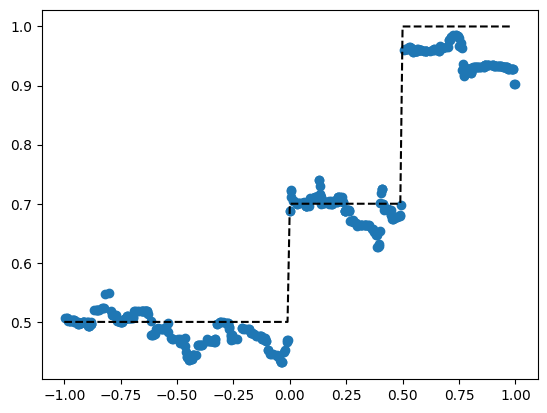

In [33]:
# 推定された治療効果を各人ごとに求めます
t_estimated = reg_1.predict(
    df[["x"]]) - reg_0.predict(df[["x"]])
plt.scatter(df[["x"]], t_estimated,
            label="estimated_treatment-effect")

# 正解のグラフを作成
x_index = np.arange(-1, 1, 0.01)
t_ans = np.zeros(len(x_index))
for i in range(len(x_index)):
    if x_index[i] < 0:
        t_ans[i] = 0.5
    elif x_index[i] >= 0 and x_index[i] < 0.5:
        t_ans[i] = 0.7
    elif x_index[i] >= 0.5:
        t_ans[i] = 1.0


# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')


## S-Learner

In [11]:
# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# モデルを学習
reg = RandomForestRegressor(max_depth=4)
X = df.loc[:, ["x", "Z"]]
reg.fit(X, df[["Y"]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [12]:
# 処置が0と1の状態を作成する
X_0 = X.copy()
X_0["Z"] = 0.0

X_1 = X.copy()
X_1["Z"] = 1.0

# ATEの計算
ATE = (reg.predict(X_1)-reg.predict(X_0)).mean()
print("ATE：", ATE)


ATE： 0.667734812161322


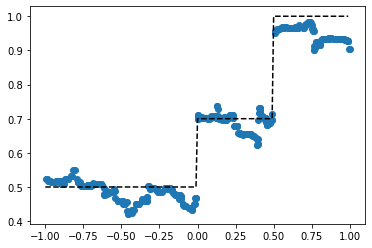

In [13]:
# 推定された治療効果を各人ごとに求めます
t_estimated = reg.predict(X_1)-reg.predict(X_0)
plt.scatter(df[["x"]], t_estimated,
            label="estimated_treatment-effect")

# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')


## X-Learner

In [14]:
# T-LearnerでM0とM1を求める
from sklearn.ensemble import RandomForestRegressor

# 集団を2つに分ける
df_0 = df[df.Z == 0.0]  # 介入を受けていない集団
df_1 = df[df.Z == 1.0]  # 介入を受けた集団

# 介入を受けていないモデル
M0 = RandomForestRegressor(max_depth=3)
M0.fit(df_0[["x"]], df_0[["Y"]])

# 介入を受けたモデル
M1 = RandomForestRegressor(max_depth=3)
M1.fit(df_1[["x"]], df_1[["Y"]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [15]:
# 推定された治療効果を各人ごとに求めます
tau_0 = reg_1.predict(df_0[["x"]]) - df_0["Y"]
tau_1 = df_1["Y"] - reg_0.predict(df_1[["x"]])

# ATTとATUを求めるモデルを作成します
M2 = RandomForestRegressor(max_depth=3)
M2.fit(df_0[["x"]], tau_0)

M3 = RandomForestRegressor(max_depth=3)
M3.fit(df_1[["x"]], tau_1)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [16]:
# 傾向スコアを求めます
from sklearn.linear_model import LogisticRegression

# 説明変数
X = df[["x"]]

# 被説明変数（目的変数）
Z = df["Z"]

# 回帰の実施
g_x = LogisticRegression().fit(X, Z)
g_x_val = g_x.predict_proba(X)

# それぞれのモデルで全データの効果を予測し、傾向スコアで調整
tau = g_x_val[:, 1]*M2.predict(df[["x"]]) + g_x_val[:, 0]*M3.predict(df[["x"]])


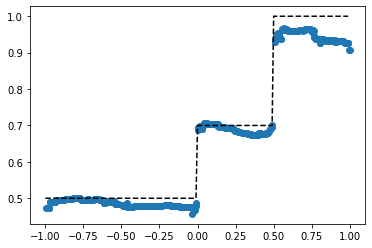

In [17]:
# 推定された治療効果を各人ごとに求めます
plt.scatter(df[["x"]], tau, label="estimated_treatment-effect")

# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')


以上